<a href="https://colab.research.google.com/github/srzarin/AtoZgeospatialsolutions/blob/master/Detectron2_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 10.6MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=db3c6524e4fbb19930b5b1f557fd0e0dea71ac971a6babff455f11cda4dbe4f6
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
pip install imgaug==0.2.6

     |████████████████████████████████| 634kB 8.7MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=8106ad32e7074e3b0df86f32d83c0d5e902c0050a25340ae63890b301af9c634
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 603kB/s 
     |████████████████████████████████| 2.2MB 11.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201104-cp36-none-any.whl size=44419 sha256=9d0e3e43589000337a8959775bd6f2d1e015d7ccd9a0abddc6d5b17a3c59df1f
  Stored in directory: /root/.cache/pip/wheels/ec/4d/40/4077356fe02ef345791713eabede5ed63afe7d613b016694d1
Successfully built fvcore
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/My Drive/Detectron/FastRcnnX101/'

/content/drive/My Drive/Detectron/FastRcnnX101


In [ ]:
ls

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_datas_train", {}, "/content/drive/My Drive/Detectron/train/_annotations.coco.json", "/content/drive/My Drive/Detectron/train")
register_coco_instances("my_datas_val", {}, "/content/drive/My Drive/Detectron/valid/_annotations.coco.json", "/content/drive/My Drive/Detectron/valid")
register_coco_instances("my_datas_test", {}, "/content/drive/My Drive/Detectron/test/_annotations.coco.json", "/content/drive/My Drive/Detectron/test")

WARNING [11/07 13:35:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/07 13:35:53 d2.data.datasets.coco]: Loaded 2335 images in COCO format from /content/drive/My Drive/Detectron/train/_annotations.coco.json


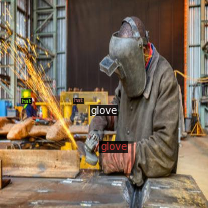

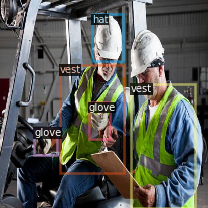

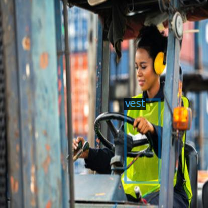

In [ ]:
my_dataset_train_metadata = MetadataCatalog.get("my_datas_train")
dataset_dicts = DatasetCatalog.get("my_datas_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_datas_train",)
cfg.DATASETS.TEST = ("my_datas_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/07 13:36:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:18, 23.4MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.


[11/07 13:36:37 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[11/07 13:37:16 d2.utils.events]:  eta: 2:42:42  iter: 19  total_loss: 2.219  loss_cls: 1.879  loss_box_reg: 0.1134  loss_rpn_cls: 0.2316  loss_rpn_loc: 0.02723  time: 1.9742  data_time: 0.0282  lr: 4.9953e-06  max_mem: 7206M
[11/07 13:37:57 d2.utils.events]:  eta: 2:48:54  iter: 39  total_loss: 2.169  loss_cls: 1.776  loss_box_reg: 0.1451  loss_rpn_cls: 0.2239  loss_rpn_loc: 0.02799  time: 2.0262  data_time: 0.0098  lr: 9.9902e-06  max_mem: 7206M
[11/07 13:38:40 d2.utils.events]:  eta: 2:52:11  iter: 59  total_loss: 1.865  loss_cls: 1.535  loss_box_reg: 0.1355  loss_rpn_cls: 0.2084  loss_rpn_loc: 0.02919  time: 2.0668  data_time: 0.0101  lr: 1.4985e-05  max_mem: 7206M
[11/07 13:39:25 d2.utils.events]:  eta: 2:53:27  iter: 79  total_loss: 1.536  loss_cls: 1.215  loss_box_reg: 0.1635  loss_rpn_cls: 0.1329  loss_rpn_loc: 0.02181  time: 2.1092  data_time: 0.0124  lr: 1.998e-05  max_mem: 7206M
[11/07 13:40:09 d2.utils.events]:  eta: 2:53:18  iter: 99  total_loss: 1.222  loss_cls: 0.8447  l

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

WARNING [11/07 16:49:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/07 16:49:55 d2.data.datasets.coco]: Loaded 2335 images in COCO format from /content/drive/My Drive/Detectron/train/_annotations.coco.json


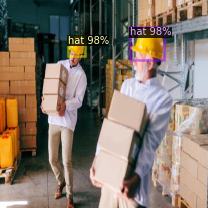

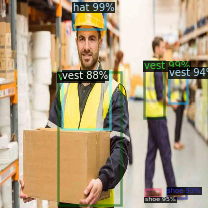

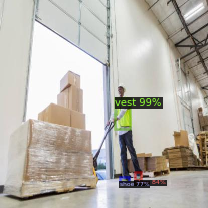

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("my_datas_train")
for d in random.sample(dataset_dicts, 3):  
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata,
                   scale=0.5, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

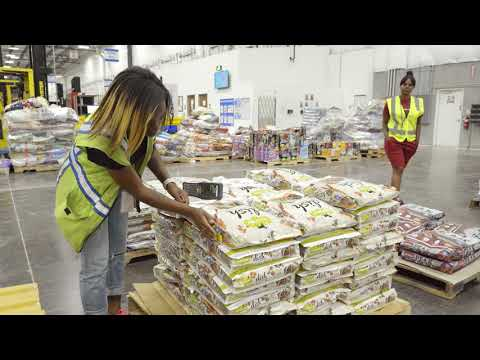

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("iWKu6WNFf9M", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python-headless opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://www.youtube.com/watch?v=iWKu6WNFf9M -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:03:40 -c:v copy video-clip.mp4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-opencv is already the newest version (3.2.0+dfsg-4ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
[youtube] iWKu6WNFf9M: Downloading webpage
[download] Destination: video.mp4
[download] 100% of 60.35MiB in 00:01
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libo

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS '/content/drive/My Drive/Detectron/output/model_final.pth'

Cloning into 'detectron2'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 8566 (delta 31), reused 39 (delta 23), pack-reused 8484
Receiving objects: 100% (8566/8566), 3.60 MiB | 5.13 MiB/s, done.
Resolving deltas: 100% (6168/6168), done.
Checking out files: 100% (611/611), done.
Failed to load OpenCL runtime
[11/07 16:50:44 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml', input=None, opts=['MODEL.WEIGHTS', '/content/drive/My Drive/Detectron/output/model_final.pth'], output='video-output.mkv', video_input='video-clip.mp4', webcam=False)
[11/07 16:50:52 fvcore.common.checkpoint]: Loading checkpoint from /content/drive/My Drive/Detectron/output/model_final.pth
WARNING [11/07 16:50:52 fvcore.common.checkpoint]: Skip loading parameter 'backbone.bottom_up.res2.0.conv1.weight' to the model due to 

In [ ]:
# Download the results
from google.colab import files
files.download('video-output.mkv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>